<a href="https://colab.research.google.com/github/otoperalias/miscellanea/blob/main/Evolucion_peso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evolución del peso de Alba y Manuel

¿Quieres actualizar la tabla? S/N: N


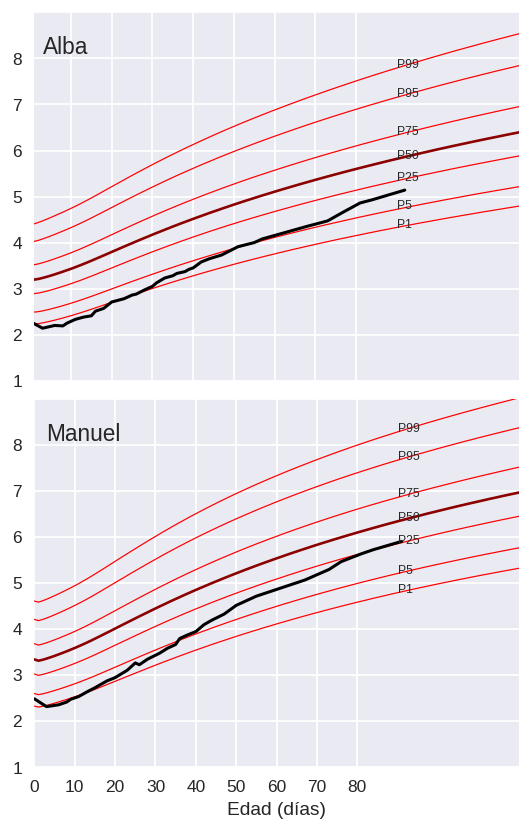

In [ ]:
# Imports (general)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
hoy=pd.to_datetime("today").strftime('%Y-%m-%d')

# Get permission to google drive
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Datos de peso de Alba y Manuel
worksheet = gc.open('Registro_peso_AM').sheet1
# Convert to a DataFrame
rows = worksheet.get_all_values()
df=pd.DataFrame.from_records(rows)
df.drop([0],inplace=True)
df.rename(columns={0:"fecha",1:"edad",2:"Alba",3:"Manuel"},inplace=True)
df=df.set_index("fecha")
df.index = pd.to_datetime(df.index)
# Update dataframe and save
update=input("¿Quieres actualizar la tabla? S/N: ")
if update=="S":
  while update=="S":
    nombre=input("Alba o Manuel: ")
    assert nombre=="Alba" or nombre=="Manuel", "Error en el nombre!"
    fecha_hoy=input("¿Fecha de hoy?: S/N ")
    if fecha_hoy=="S":
      fecha=hoy
    else:
      fecha=input("Fecha: XXXX-XX-XX (Año/Mes/Día): ")
    peso=input("Peso (decimales con punto): ")
    df.loc[fecha,nombre]=peso
    update=input("¿Quieres actualizar MÁS la tabla? S/N: ")
  # Actualizar
  import gspread_dataframe as gd
  gd.set_with_dataframe(worksheet, df.reset_index())
# Procesamos datos
df["a"]=df["Alba"]
df["m"]=df["Manuel"]
df["a"]=pd.to_numeric(df["a"],errors='coerce')
df["m"]=pd.to_numeric(df["m"],errors='coerce')
df["edad"]=pd.to_numeric(df["edad"],errors='coerce')
# Restar peso de pañal y body (excepto primeras dos medidas en el hospital)
df.loc["2021-11-27":,["a","m"]]=df.loc["2021-11-27":,["a","m"]]-0.06
# Interpolación lineal
  # Alba
df_nona_a = df.dropna(subset = ['a'])
f = interp1d(df_nona_a['edad'], df_nona_a['a'])
fechamax_a=df["a"][pd.notnull(df.a)].idxmax()
df.loc[:fechamax_a,"a"] = f(df.loc[:fechamax_a,'edad'])
  # Manuel
df_nona_m = df.dropna(subset = ['m'])
f = interp1d(df_nona_m['edad'], df_nona_m['m'])
fechamax_m=df["m"][pd.notnull(df.m)].idxmax()
df.loc[:fechamax_m,"m"] = f(df.loc[:fechamax_m,'edad'])
  # Set Age as index
df=df.set_index("edad")

# Growth standards
for sex in ["girls","boys"]: 
  if sex=="girls":
    standards = gc.open('Growth_standards').worksheet("wfa_girls_p_exp")
  else:
    standards = gc.open('Growth_standards').worksheet("wfa_boys_p_exp")
  rows = standards.get_all_values()
  table=pd.DataFrame.from_records(rows)
  colnames=list(table.iloc[0])
  table.drop([0],inplace=True)
  for c in range(0,len(colnames)):
    table.rename(columns={table.columns[c]:colnames[c]},inplace=True)
  table=table.set_index("Age")
  table = table.apply(pd.to_numeric)
  globals()[sex]=table.copy()

  # GRÁFICO
plt.style.use('seaborn')
fig,(ax1,ax2)=plt.subplots(2,figsize=(5,8),sharex=True, dpi=125)
# Alba
girls[["P1","P5","P25","P50","P75","P95","P99"]].plot(ax=ax1, color="red",lw=0.7)
girls["P50"].plot(ax=ax1, color="darkred",lw=1.5)
df["a"].plot(ax=ax1,color="black")
ax1.get_legend().remove()
ax1.set_xlim(1,120) #max(fechamax_a,fechamax_m))
ax1.set_ylim(1,9) 
ax1.text(3,8.1,"Alba",size=13)
ax1.set_yticklabels([x for x in np.arange(1, 9, 1)])
for p in ["P1","P5","P25","P50","P75","P95","P99"]:
  ax1.text(90,girls[p].iloc[90],p,size=7)
# Manuel
boys[["P1","P5","P25","P50","P75","P95","P99"]].plot(ax=ax2, color="red",lw=0.7)
boys["P50"].plot(ax=ax2, color="darkred",lw=1.5)
df["m"].plot(ax=ax2,color="black")
ax2.get_legend().remove()
ax2.set_xlim(1,120) #max(fechamax_a,fechamax_m))
ax2.set_ylim(1,9)
ax2.text(3,8.1,"Manuel",size=13)
ax2.set_xlabel("Edad (días)")
ax2.set_xticks(np.arange(0, 90, 10))
ax2.set_xticklabels([x for x in np.arange(0, 90, 10)])
ax2.set_yticklabels([x for x in np.arange(1, 9, 1)])
for p in ["P1","P5","P25","P50","P75","P95","P99"]:
  ax2.text(90,boys[p].iloc[90],p,size=7)
plt.subplots_adjust(hspace=0.05)
plt.show()